## 1 - Importing Required Libraries  

Before implementing **Logistic Regression**, we first import essential Python libraries for numerical computations, image processing, and data handling.  

### **Libraries Used:**
- **`numpy`** → Supports efficient array operations and mathematical computations.  
- **`scipy`** → Provides scientific computing functions, including image processing via `ndimage`.  
- **`matplotlib.pyplot`** → Used for visualizing images and plotting graphs.  
- **`h5py`** → Handles `.h5` datasets (HDF5 format) used for storing large amounts of numerical data.  
- **`PIL (Python Imaging Library)`** → Allows for opening, manipulating, and converting images.  
- **`skimage.io`** → Supports advanced image loading and processing functions.  
- **`lr_utils`** → A helper module that contains the `load_dataset()` function to load training and test datasets.  

### **Notebook Settings:**
- **`%matplotlib inline`** → Ensures that all plots generated by `matplotlib` appear directly within the Jupyter Notebook.

In [2]:
import numpy as np
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from lr_utils import load_dataset
import skimage.io
from skimage.io import imread

%matplotlib inline

## 2 - Loading and Preprocessing the Dataset  

### **Dataset Overview**  
We use the `load_dataset()` function to load images of **cats (label = 1)** and **non-cats (label = 0)**. The dataset consists of:  
- A **training set** (`train_set_x_orig`, `train_set_y`)  
- A **test set** (`test_set_x_orig`, `test_set_y`)  
- A **list of class labels** (`classes`)  

### **Loading and Exploring the Data**  
We first check the dimensions of our dataset to understand its structure:  

### **Visualizing an Example Image**
To confirm the dataset is correctly loaded, we display an example image.
- plt.imshow(train_set_x_orig[index]) → Displays the 10th image in the dataset.
- train_set_y[:, index] → Retrieves the label (0 for non-cat, 1 for cat).
- classes[np.squeeze(train_set_y[:, index])] → Converts the label into its corresponding class name ("cat" or "non-cat").

### **Flattening the Dataset**
Since neural networks work with 1D feature vectors, we flatten each image (convert it into a vector) while preserving the number of training examples.
This transforms:
- (m_train, 64, 64, 3) → (12288, m_train)
- (m_test, 64, 64, 3) → (12288, m_test)


### **Standardizing the Data**
Pixel values in images range from 0 to 255. To improve training stability, we normalize the dataset by scaling pixel values between 0 and 1. This ensures all features have the same range, which helps the neural network learn efficiently.

In [3]:
# Loading the data (cat/non-cat): we have 5 variable: train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
# Print the dimensions with appropriate formatting
print("Training set X shape:", train_set_x_orig.shape)
print("Training set Y shape:", train_set_y.shape)
print("Test set X shape:", test_set_x_orig.shape)
print("Test set Y shape:", test_set_y.shape)
print("Classes shape:", classes.shape)
#----------------------------------------------------------------------------------------------------------------------------
# # Example of a picture
# index =10
# plt.imshow(train_set_x_orig[index])
# print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")
#----------------------------------------------------------------------------------------------------------------------------
#Reshape the training and test data sets
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0])
train_set_x_flatten_dim=train_set_x_flatten.shape
test_set_x_flatten_dim=test_set_x_flatten.shape
print("train_set_x_flatten:",train_set_x_flatten_dim)
print("test_set_x_flatten:",test_set_x_flatten_dim)
#----------------------------------------------------------------------------------------------------------------------------
#preprocess and standardize the training and test data sets
train_set_x=train_set_x_flatten/255
test_set_x=test_set_x_flatten/255

Training set X shape: (209, 64, 64, 3)
Training set Y shape: (1, 209)
Test set X shape: (50, 64, 64, 3)
Test set Y shape: (1, 50)
Classes shape: (2,)
train_set_x_flatten: (12288, 209)
test_set_x_flatten: (12288, 50)


## 3 - Implementing Logistic Regression  

In this section, we implement a **Logistic Regression model** using **NumPy** to classify images as **cat (1) or non-cat (0)**. 

### **Mathematical Formulation**  

For a given input example  $x^{(i)}$, logistic regression performs the following computations:

1. **Linear Combination of Inputs:**  
   $
   z^{(i)} = w^T x^{(i)} + b
   $
   where:
   - $w$ is the weight vector,
   - $x^{(i)}$ is the input feature vector,
   - $b$ is the bias term.

2. **Sigmoid Activation Function:**  
   The output $z^{(i)}$  is passed through the **sigmoid function** to convert it into a probability:

   $
   \hat{y}^{(i)} = a^{(i)} = \sigma(z^{(i)}) = \frac{1}{1 + e^{-(w^T x + b)}}
   $

   This ensures that the output is always between **0 and 1**, representing the probability of the input belonging to class 1.

3. **Loss Function (Binary Cross-Entropy):**  
   To measure how well the model’s predictions match the true labels, we use the **log loss** function:

   $
   \mathcal{L}(a^{(i)}, y^{(i)}) = - y^{(i)} \log(a^{(i)}) - (1 - y^{(i)}) \log(1 - a^{(i)})
   $

   - If $y^{(i)} = 1$, the second term vanishes, and the loss is high when $a^{(i)}$ is close to **0**.
   - If $y^{(i)} = 0$, the first term vanishes, and the loss is high when $a^{(i)}$ is close to **1**.

4. **Cost Function (Averaged Loss Over All Examples):**  
   The overall cost function is the **average** loss over all training examples:

   $
   J = \frac{1}{m} \sum_{i=1}^{m} \mathcal{L}(a^{(i)}, y^{(i)})
   $

   where $m$ is the total number of training examples.

---

### **Implementation Steps**  

To implement logistic regression, we follow these key steps:

✅ **1. Initialize Parameters**  
- Set the weight vector $w$ to **zeros** with shape **(num_features, 1)**.  
- Set the bias $b$ to **0**.

✅ **2. Forward Propagation (Compute Predictions & Cost)**  
- Compute **$z$** using the equation $z = w^T X + b$.
- Apply the **sigmoid function** to obtain **predicted probabilities** $\hat{y}$.
- Compute the **cost function** $J$ using **binary cross-entropy**.

✅ **3. Backward Propagation (Compute Gradients)**  
- Compute the **gradient of the cost function** with respect to parameters:
  $
  \frac{\partial J}{\partial W} = \frac{1}{m} X (A - Y)^T, \quad \frac{\partial J}{\partial b} = \frac{1}{m} \sum (A - Y)
  $

✅ **4. Optimize Parameters (Gradient Descent Update)**  
- Update weights and bias using the **gradient descent rule**:
  $
  W = W - \alpha dW, \quad b = b - \alpha db
  $
  where $\alpha$ is the **learning rate**.

✅ **5. Make Predictions**  
- Use the trained parameters to compute $\hat{y}$ on new examples.
- Convert probabilities into class labels:  
  $
  \hat{y} = \begin{cases} 
  1, & A \geq 0.5 \\ 
  0, & A < 0.5 
  \end{cases}
  $

✅ **6. Evaluate Model Performance**  
- Compute **accuracy** on training and test datasets.

Each of these steps is implemented in separate functions and will be integrated into a single function called **`model()`**, which will train the logistic regression classifier and make predictions.  

By the end of this implementation, we will have a fully functional **binary classifier** capable of distinguishing between cat and non-cat images! 🚀


In [4]:
# 1.sigmoid function:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1/(1+np.exp(-z))
    return s


In [5]:
# 2.parameter initialization function:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b


In [6]:
# 3.Forward and Backward propagation function:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X) + b)              # compute activation
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m  # compute cost
    
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())  #cost is expected to be a scalar (a single number, not an array).
                              #For scalars, cost.shape should be an empty tuple ().
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [7]:
#4. Optimization function:

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs


In [8]:
# 5.Predict function: 
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X) + b)           # Dimentions = (1, m)
    
    #### WORKING SOLUTION 1: USING IF ELSE #### 
    #for i in range(A.shape[1]):
        ## Convert probabilities A[0,i] to actual predictions p[0,i]
        #if (A[0,i] >= 0.5):
        #    Y_prediction[0, i] = 1
        #else:
        #    Y_prediction[0, i] = 0
        
    #### WORKING SOLUTION 2: ONE LINE ####
    #for i in range(A.shape[1]):
        ## Convert probabilities A[0,i] to actual predictions p[0,i]
        #Y_prediction[0, i] = 1 if A[0,i] >=0.5 else 0
    
    #### WORKING SOLUTION 3: VECTORISED IMPLEMENTATION ####
    Y_prediction = (A >= 0.5) * 1.0   #The result of A >= 0.5 is a Boolean array: True where A >= 0.5, and False otherwise.
    #Multiplying by 1.0 converts the Boolean values to numeric values: True becomes 1.0 False becomes 0.0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [9]:
# Merge all functions into a model
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

## 6 - Further Analysis: Choice of Learning Rate  

### **Why Does Learning Rate Matter?**  
The **learning rate** $\alpha$ is a crucial hyperparameter that controls how much the model’s parameters $W$ and $b$ are updated during **gradient descent**. Choosing an appropriate learning rate is essential for efficient training and convergence.  

### **Impact of Different Learning Rates**  

1. **Too High ($\alpha$ is large)**  
   - The model may **diverge** instead of converging.  
   - The cost function oscillates and fails to reach a minimum.  
   - Training may become unstable.  

2. **Too Low ($\alpha$ is small)**  
   - The model converges **very slowly**, requiring many iterations.  
   - Training becomes computationally expensive.  

3. **Optimal Learning Rate**  
   - Allows the model to converge at a reasonable speed.  
   - Avoids oscillations and ensures stability.  
   - Results in a well-trained model within a reasonable number of iterations.  

### **Visualizing Learning Rate Effects**  
We compare different learning rates by plotting the **cost function vs. number of iterations** for multiple values of $\alpha$.  

train accuracy: 91.38755980861244 %
test accuracy: 34.0 %
y = 0, you predicted that it is a "non-cat" picture.


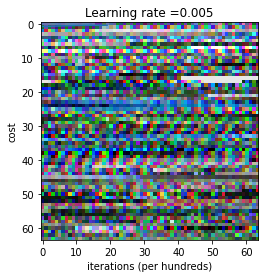

In [10]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

# Example of a picture that was wrongly classified.
index = 29
plt.imshow(test_set_x[:,index].reshape((64, 64, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")
#----------------------------------------------------------------------------------------------------------------------------
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

## Test the model with your own image

C:\Users\dell\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  del sys.path[0]


y = 0.0, your algorithm predicts a "non-cat" picture.


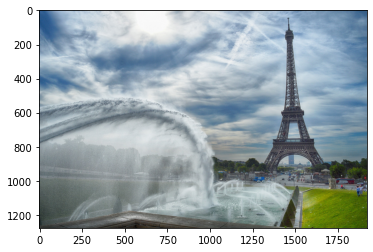

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread  #imread from imageio: Reads images from a file and returns them as arrays
from PIL import Image #PIL (Image): Provides functions to manipulate images, including resizing.


# Replace with your image name
my_image = "my_image.jpg"
num_px = 64  # Example size for resizing

# Load and preprocess the image
fname = "images/" + my_image  #Constructs the file path for the image by combining the directory and file name.
image = np.array(imread(fname))  # imread(fname): Reads the image file as an array of pixel values.
                                 # np.array(): Ensures the image is a NumPy array.
image = image / 255.0  # Normalize pixel values to [0, 1]

# Resize and reshape the image
image_resized = np.array(Image.fromarray((image * 255).astype('uint8')).resize((num_px, num_px))) / 255.0 #**explanation is below
my_image = image_resized.reshape((1, num_px * num_px * 3)).T  #Flattens the image into a 1D array of shape (1, 64*64*3) (one row for all pixel values).

# Prediction (assuming d["w"], d["b"] exist and are defined)
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + 
      ", your algorithm predicts a \"" + 
      classes[int(np.squeeze(my_predicted_image))].decode("utf-8") + "\" picture.")
